In [2]:
# Necessary library importing
import keras
import keras.backend as K
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.preprocessing import StandardScaler

from keras.layers import Dense, Dropout, LSTM, Activation
from keras.layers.core import Activation
from keras.models import Sequential,load_model

# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0
%matplotlib inline

In [3]:
# Training data 
train_data = 'https://raw.githubusercontent.com/joshuataeyong/Hanwha/main/train_FD001.txt'
train_df = pd.read_csv(train_data, sep=" ", header=None) 
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True) # last two columns are blank 
train_df.columns = ['EngineID', 'cycle', 'OPsetting1', 'OPsetting2', 'OPsetting3', 's1', 's2', 's3', 
                    's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21'] 

# Test data 
test_data = 'https://raw.githubusercontent.com/joshuataeyong/Hanwha/main/test_FD001.txt'
test_df = pd.read_csv(test_data, sep=" ", header=None) 
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)  
test_df.columns = ['EngineID', 'cycle', 'OPsetting1', 'OPsetting2', 'OPsetting3', 's1', 's2', 's3', 
                   's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21'] 

# Actual RUL for each engine-id in the test data 
truth_data = 'https://raw.githubusercontent.com/joshuataeyong/Hanwha/main/RUL_FD001.txt'
truth_df = pd.read_csv(truth_data, sep=" ", header=None) 
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True) # 2nd column is blank  
truth_df.columns = ['finalRUL'] # assigning column name as finalRUL 
truth_df['EngineID'] = truth_df.index + 1 # adding new column EngineID 


In [4]:
# Find max Engine Cycle for train data
maxCycle_df = pd.DataFrame(train_df.groupby('EngineID')['cycle'].max()).reset_index()  
maxCycle_df.columns = ['EngineID', 'maxEngineCycle'] 

# Compute engine RUL for train data
train_df = train_df.merge(maxCycle_df, on=['EngineID'], how='left')  
train_df['engineRUL'] = train_df['maxEngineCycle'] - train_df['cycle'] 
train_df.drop('maxEngineCycle', axis=1, inplace=True)

# Generate binary label for train data
w1 = 30 
train_df['binaryLabel'] = np.where(train_df['engineRUL'] <= w1, 1, 0 ) 
train_df

,EngineID,cycle,OPsetting1,OPsetting2,OPsetting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,engineRUL,binaryLabel
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4,1
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3,1
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2,1
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1,1


In [5]:
# Compute maxEngineCycle for test data using data from test_df and truth_df  

maxCycle_df  = pd.DataFrame(test_df.groupby('EngineID')['cycle'].max()).reset_index() 
maxCycle_df.columns = ['EngineID', 'maxEngineCycle'] 
truth_df['maxEngineCycle'] = maxCycle_df ['maxEngineCycle'] + truth_df['finalRUL']  
truth_df.drop('finalRUL', axis=1, inplace=True) 

# Generate engineRUL & binary label for test data 
test_df = test_df.merge(truth_df, on=['EngineID'], how='left') 
test_df['engineRUL'] = test_df['maxEngineCycle'] - test_df['cycle'] 
test_df.drop('maxEngineCycle', axis=1, inplace=True) 

test_df['binaryLabel'] = np.where(test_df['engineRUL'] <= w1, 1, 0 ) 
test_df

,EngineID,cycle,OPsetting1,OPsetting2,OPsetting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,engineRUL,binaryLabel
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,24,1
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,23,1
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,22,1
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,21,1


In [6]:
# Training dataset: create temporary dataframe with columns to be scaled 
all_cols = train_df.columns # get columns names 
cols_to_scale = train_df.columns.difference(['EngineID','cycle','engineRUL','binaryLabel']) 
train_df_with_cols_to_scale = train_df[cols_to_scale] 

# Scale and rejoin with columns that were not scaled 
scaler = StandardScaler() 
scaled_train_df_with_cols_to_scale = pd.DataFrame(scaler.fit_transform(train_df_with_cols_to_scale), columns=cols_to_scale) 
train_df_scaled = train_df[['EngineID','cycle','engineRUL','binaryLabel']].join(scaled_train_df_with_cols_to_scale) 
train_df_scaled = train_df_scaled.reindex(columns = all_cols) 
train_df_scaled

,EngineID,cycle,OPsetting1,OPsetting2,OPsetting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,engineRUL,binaryLabel
0,1,1,-0.315980,-1.372953,0.0,0.0,-1.721725,-0.134255,-0.925936,-1.776357e-15,...,-0.269071,-0.603816,-1.387779e-17,-0.781710,0.0,0.0,1.348493,1.194427,191,0
1,1,2,0.872722,-1.031720,0.0,0.0,-1.061780,0.211528,-0.643726,-1.776357e-15,...,-0.642845,-0.275852,-1.387779e-17,-0.781710,0.0,0.0,1.016528,1.236922,190,0
2,1,3,-1.961874,1.015677,0.0,0.0,-0.661813,-0.413166,-0.525953,-1.776357e-15,...,-0.551629,-0.649144,-1.387779e-17,-2.073094,0.0,0.0,0.739891,0.503423,189,0
3,1,4,0.324090,-0.008022,0.0,0.0,-0.661813,-1.261314,-0.784831,-1.776357e-15,...,-0.520176,-1.971665,-1.387779e-17,-0.781710,0.0,0.0,0.352598,0.777792,188,0
4,1,5,-0.864611,-0.690488,0.0,0.0,-0.621816,-1.251528,-0.301518,-1.776357e-15,...,-0.521748,-0.339845,-1.387779e-17,-0.136018,0.0,0.0,0.463253,1.059552,187,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.178822,-1.031720,0.0,0.0,1.618000,1.216258,2.188375,-1.776357e-15,...,-0.322542,1.425294,-1.387779e-17,2.446751,0.0,0.0,-1.805173,-2.921113,4,1
20627,100,197,-0.727453,-1.714186,0.0,0.0,1.717992,2.279706,2.738351,-1.776357e-15,...,-0.380207,1.913240,-1.387779e-17,1.155367,0.0,0.0,-2.856395,-1.203764,3,1
20628,100,198,0.186933,-0.008022,0.0,0.0,1.478011,1.946971,2.138377,-1.776357e-15,...,-0.141684,3.265092,-1.387779e-17,3.092444,0.0,0.0,-2.081810,-3.292481,2,1
20629,100,199,-0.498857,1.015677,0.0,0.0,1.098043,2.403666,1.955051,-1.776357e-15,...,-0.233948,2.579834,-1.387779e-17,1.155367,0.0,0.0,-2.911722,-2.085072,1,1


In [ ]:
# Test dataset: create temporary dataframe with columns to be scaled 
all_cols = test_df.columns 
test_df_with_cols_to_scale = test_df[cols_to_scale] 

# Scale and rejoin with columns that were not scaled 
scaled_test_df_with_cols_to_scale = pd.DataFrame(scaler.transform(test_df_with_cols_to_scale), columns=cols_to_scale) 
test_df_scaled = test_df[['EngineID','cycle','engineRUL','binaryLabel']].join(scaled_test_df_with_cols_to_scale) 
test_df_scaled = test_df_scaled.reindex(columns = all_cols) # same columns order as before 
test_df_scaled

,EngineID,cycle,OPsetting1,OPsetting2,OPsetting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,engineRUL,binaryLabel
0,1,1,1.055599,1.015677,0.0,0.0,0.678077,-0.853550,-1.191480,-1.776357e-15,...,-0.954235,-0.985107,-1.387779e-17,-0.781710,0.0,0.0,0.241943,0.774097,142,0
1,1,2,-1.230366,-1.031720,0.0,0.0,-1.941707,-0.338137,-1.501467,-1.776357e-15,...,-0.216648,-1.649034,-1.387779e-17,-0.136018,0.0,0.0,1.127183,0.941305,141,0
2,1,3,0.141213,0.333211,0.0,0.0,-0.441831,-0.584426,-0.843717,-1.776357e-15,...,-0.715712,0.052112,-1.387779e-17,-0.136018,0.0,0.0,1.459148,1.172256,140,0
3,1,4,1.924266,-0.008022,0.0,0.0,-0.481827,-1.044384,-0.279297,-1.776357e-15,...,-0.568929,-1.345067,-1.387779e-17,-1.427402,0.0,0.0,1.016528,0.775945,139,0
4,1,5,0.644125,-0.008022,0.0,0.0,-0.341839,-0.543650,-0.779276,-1.776357e-15,...,-0.745069,-1.041101,-1.387779e-17,-2.073094,0.0,0.0,0.961200,1.138999,138,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,2.244301,-0.008022,0.0,0.0,1.118041,1.456023,0.761769,-1.776357e-15,...,3.644806,0.782698,-1.387779e-17,0.509675,0.0,0.0,-0.919933,-0.852719,24,1
13092,100,195,-0.498857,-0.349255,0.0,0.0,1.078044,0.842747,1.457295,-1.776357e-15,...,3.517419,0.241425,-1.387779e-17,1.155367,0.0,0.0,-1.362553,-0.116449,23,1
13093,100,196,-0.270260,-1.031720,0.0,0.0,1.518008,0.428459,-0.234855,-1.776357e-15,...,3.852400,0.393408,-1.387779e-17,1.155367,0.0,0.0,-1.085916,-0.781586,22,1
13094,100,197,-1.733278,0.333211,0.0,0.0,1.158038,0.728573,1.158419,-1.776357e-15,...,4.022249,0.772033,-1.387779e-17,1.155367,0.0,0.0,-0.864606,-0.182962,21,1


In [ ]:
# Initiating sequencing samples 
nSequenceSteps = 50   # number of cycles in a sequence 
X_train_sequence = [] 
y_train_sequence = [] 

# Define utility function 
def generate_LSTM_samples(engine_df, nSequenceSteps): 
    """ 
 This function generates list of LSTM samples (numpy arrays of size (nSequenceSteps, 24) 
         each) for LSTM input and list of output labels for LSTM 
    """ 
    engine_X_train_sequence = [] 
    engine_y_train_sequence = [] 
    engine_data = engine_df.values # converting to numpy 
     
    for sample in range(nSequenceSteps, engine_data.shape[0]): 
        engine_X_train_sequence.append(engine_data[sample-nSequenceSteps:sample,:-1]) 
        engine_y_train_sequence.append(engine_data[sample,-1]) 
     
    return engine_X_train_sequence, engine_y_train_sequence 


In [ ]:
# Generate sequence samples 

for engineID in train_df_scaled['EngineID'].unique(): 
    engine_df = train_df_scaled[train_df_scaled['EngineID'] == engineID] 
    engine_df = engine_df[['OPsetting1', 'OPsetting2', 'OPsetting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7',  
    's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'binaryLabel']] 
    engine_X_train_sequence, engine_y_train_sequence = generate_LSTM_samples(engine_df, nSequenceSteps) 
     
    X_train_sequence = X_train_sequence + engine_X_train_sequence # adding samples to the common list 
    y_train_sequence = y_train_sequence + engine_y_train_sequence 

X_train_sequence, y_train_sequence = np.array(X_train_sequence), np.array(y_train_sequence)


In [ ]:
# Generate validation dataset
from sklearn.model_selection import train_test_split 

X_est_sequence, X_val_sequence, y_est_sequence, y_val_sequence = train_test_split(X_train_sequence, y_train_sequence, stratify=y_train_sequence, test_size = 0.3, random_state = 100) 


In [ ]:
# Build and compile the LSTM model
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Dropout 

# Define model 
model = Sequential() 
model.add(LSTM(units=100, return_sequences=True, input_shape=(nSequenceSteps, 24))) 
model.add(Dropout(0.2)) 
model.add(LSTM(units=50)) 
model.add(Dropout(0.2)) 
model.add(Dense(1, activation='sigmoid')) 

# Compile model 
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy']) 
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50, 100)           50000     
                                                                 
 dropout_4 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 80,251
Trainable params: 80,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit the model
from tensorflow.keras.callbacks import EarlyStopping 

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) 
history = model.fit(X_est_sequence, y_est_sequence, epochs=100, batch_size=250, 
validation_data=(X_val_sequence, y_val_sequence), callbacks=[es]) 


Epoch 1/100
44/44 [==============================] - 18s 315ms/step - loss: 0.2488 - accuracy: 0.8897 - val_loss: 0.1252 - val_accuracy: 0.9475
Epoch 2/100
44/44 [==============================] - 13s 296ms/step - loss: 0.0990 - accuracy: 0.9606 - val_loss: 0.0753 - val_accuracy: 0.9695
Epoch 3/100
44/44 [==============================] - 14s 312ms/step - loss: 0.0746 - accuracy: 0.9700 - val_loss: 0.0821 - val_accuracy: 0.9684
Epoch 4/100
44/44 [==============================] - 14s 310ms/step - loss: 0.0683 - accuracy: 0.9721 - val_loss: 0.0598 - val_accuracy: 0.9757
Epoch 5/100
44/44 [==============================] - 14s 320ms/step - loss: 0.0605 - accuracy: 0.9750 - val_loss: 0.0587 - val_accuracy: 0.9765
Epoch 6/100
44/44 [==============================] - 13s 295ms/step - loss: 0.0560 - accuracy: 0.9783 - val_loss: 0.0646 - val_accuracy: 0.9736
Epoch 7/100
44/44 [==============================] - 13s 294ms/step - loss: 0.0532 - accuracy: 0.9782 - val_loss: 0.0442 - val_accuracy:

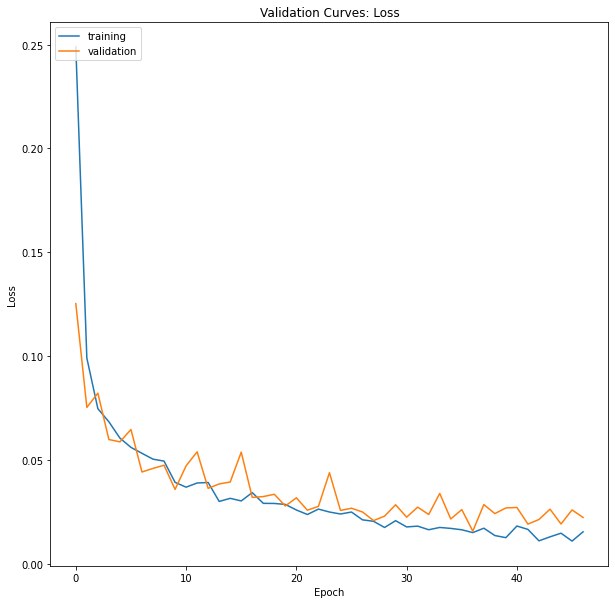

In [ ]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Validation Curves: Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


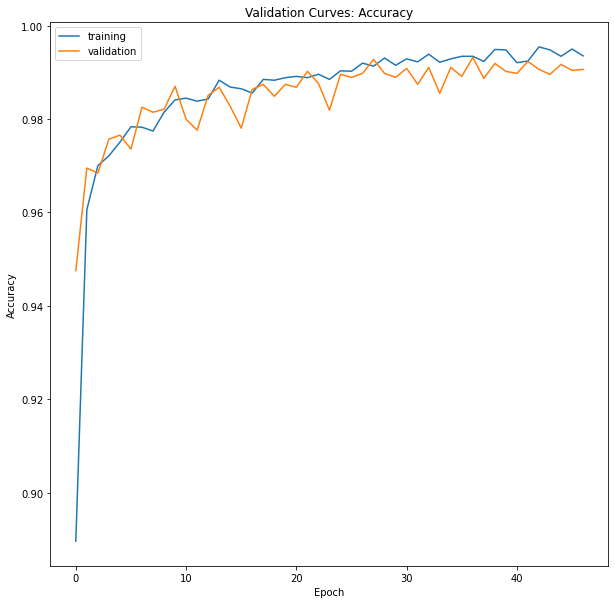

55/55 [==============================] - 4s 77ms/step - loss: 0.0096 - accuracy: 0.9957

Accuary: 0.9957042336463928
55/55 [==============================] - 5s 76ms/step


In [ ]:
# list all data in history
print(history.history.keys())

# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Validation Curves: Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

# training metrics
scores = model.evaluate(X_est_sequence, y_est_sequence, verbose=1, batch_size=200)
print('\nAccuary: {}'.format(scores[1]))
# print('\nR^2: {}'.format(scores[2]))

y_pred = model.predict(X_est_sequence,verbose=1, batch_size=200)
y_true = y_est_sequence

test_set = pd.DataFrame(y_pred)



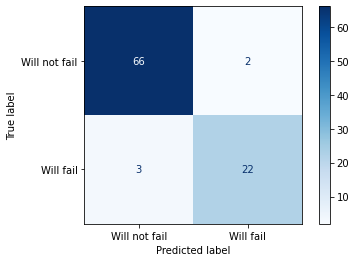

In [ ]:
# Evaluation with test set
# Input/output test sequences (only the last sequence is used to predict failure) 
X_test_sequence = [] 
y_test_sequence = [] 

for engineID in test_df_scaled['EngineID'].unique(): 
    engine_df = test_df_scaled[test_df_scaled['EngineID'] == engineID] 
    
    if engine_df.shape[0] >= nSequenceSteps:
      engine_df = engine_df[['OPsetting1', 'OPsetting2', 'OPsetting3', 's1', 's2', 's3', 's4', 's5', 's6',  's7', 
                             's8', 's9', 's10', 's11', 's12', 's13', 's14',  's15', 's16', 's17', 's18', 's19', 's20', 's21', 'binaryLabel']].values 
      X_test_sequence.append(engine_df[-nSequenceSteps:,:-1]) 
      y_test_sequence.append(engine_df[-1,-1]) 
         
X_test_sequence, y_test_sequence = np.array(X_test_sequence), np.array(y_test_sequence) 

# Predict test labels 
y_test_sequence_pred = model.predict(X_test_sequence) > 0.5 # probabilities to binaryLabels 
conf_matrix_test = confusion_matrix(y_test_sequence, y_test_sequence_pred)

# Confusion matrix visualization
from sklearn.metrics import ConfusionMatrixDisplay
labels = ["Will not fail", "Will fail"]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

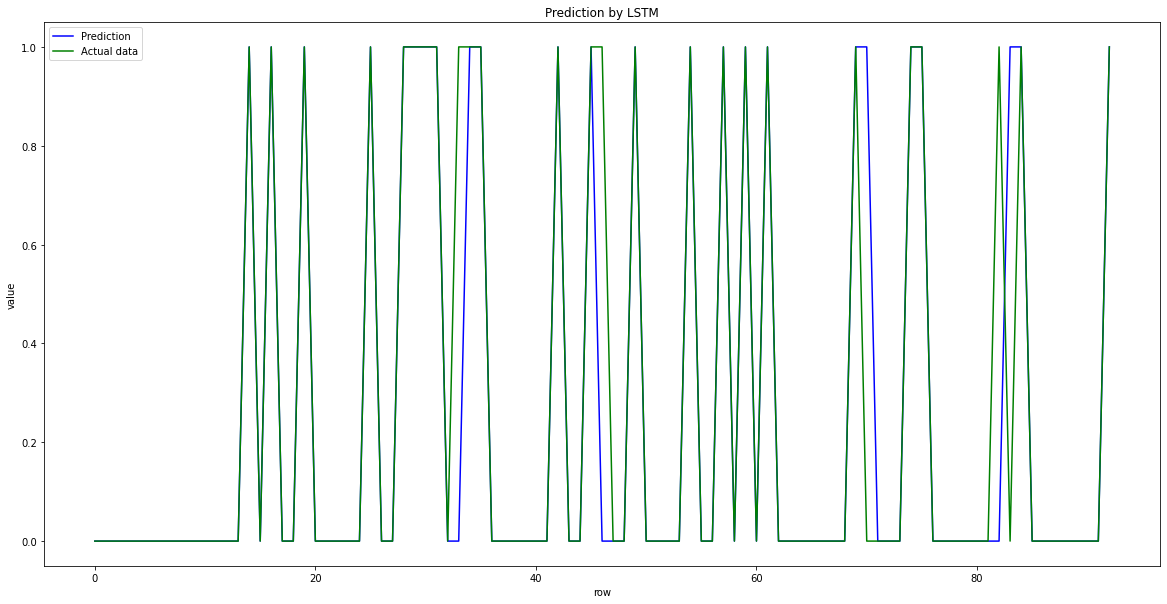

In [ ]:
# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(20, 10))
plt.plot(y_test_sequence_pred>0.5, color="blue")
plt.plot(y_test_sequence, color="green")
plt.title('Prediction by LSTM')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['Prediction', 'Actual data'], loc='upper left')
plt.show()    